In [6]:
import cv2 as cv
import numpy as np
import scipy.linalg as la
import scipy as sp
import matplotlib.pyplot as plt
from scipy.interpolate import griddata

# Simple image displaying

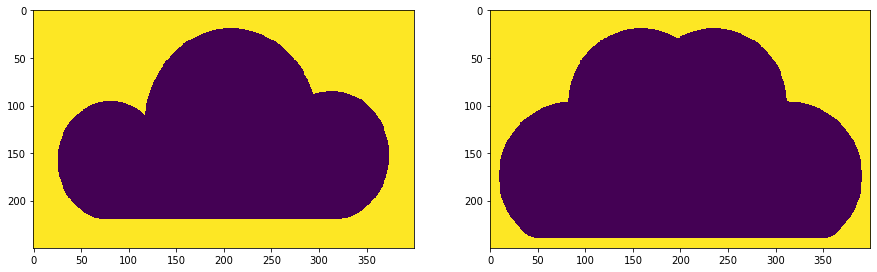

In [11]:
w = 400
h = 250

cloud_1_raw = cv.imread("Images/cloud_1.png")
cloud_2_raw = cv.imread("Images/cloud_2.png")
cloud_1_raw = cv.resize(cloud_1_raw, (w, h))
cloud_2_raw = cv.resize(cloud_2_raw, (w, h))

R = np.zeros((h, w))
T_raw = np.zeros((h, w))

# Convert images to normalized 2D numpy arrays
for i in range(h):
    for j in range(w):
        R[i][j] = sum(cloud_1_raw[i][j]) // 665
        T_raw[i][j] = sum(cloud_2_raw[i][j]) // 665

plt.figure(figsize=(15, 8))
plt.subplot(1, 2, 1)
plt.imshow(R)
plt.subplot(1, 2, 2)
plt.imshow(T_raw)

# Function definitions

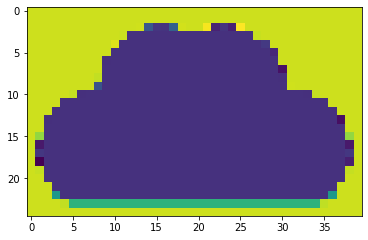

In [23]:
x = np.arange(h) # These are flipped because our "image" is a matrix
y = np.arange(w)
T = sp.interpolate.RectBivariateSpline(x, y, T_raw) # Interpolation of our image

# Plot the interpolation on a new grid to ensure it worked
Z = T(np.linspace(0, h-1, h//10), np.linspace(0, w-1, w//10)) # evaluation of the function on the grid
plt.imshow(Z) # drawing the function
plt.show()

In [35]:
# Linearly transforms interpolated function T from parameters p and returns new function
# p = p1, p2, p3, p4, p5, p6
# p1-p4 form a matrix:
# (p1 p2)
# (p3 p4)
# Which defines a linear transformation about the center, (p5, p6) is translation
def trafo(T, p, w, h):
    def mapped_T(x, y):
        #Translate to center
        x0 = x - h // 2
        y0 = y - w // 2
        
        #Apply transformation and translation
        x = p[0] * x0 + p[1] * y0 + h // 2 - p[4]
        y = p[2] * x0 + p[3] * y0 + w // 2 - p[5]
        print(x)
        return T(x, y)
    return mapped_T

T_transformed = trafo(T, [1, 0, 0, 1, 0, 0], w, h)
# Plot the identity transformed T
Z = T_transformed(np.linspace(0, h-1, h//10)[:, None], np.linspace(0, w-1, w//10)[None, :]) # evaluation of the function on the grid
plt.imshow(Z) # drawing the function
plt.show()

[[1.]]
[[  0.      0.      0.      0.      0.      0.      0.      0.      0.
    0.      0.      0.      0.      0.      0.      0.      0.      0.
    0.      0.      0.      0.      0.      0.      0.      0.      0.
    0.      0.      0.      0.      0.      0.      0.      0.      0.
    0.      0.      0.      0.   ]
 [ 10.375  10.375  10.375  10.375  10.375  10.375  10.375  10.375  10.375
   10.375  10.375  10.375  10.375  10.375  10.375  10.375  10.375  10.375
   10.375  10.375  10.375  10.375  10.375  10.375  10.375  10.375  10.375
   10.375  10.375  10.375  10.375  10.375  10.375  10.375  10.375  10.375
   10.375  10.375  10.375  10.375]
 [ 20.75   20.75   20.75   20.75   20.75   20.75   20.75   20.75   20.75
   20.75   20.75   20.75   20.75   20.75   20.75   20.75   20.75   20.75
   20.75   20.75   20.75   20.75   20.75   20.75   20.75   20.75   20.75
   20.75   20.75   20.75   20.75   20.75   20.75   20.75   20.75   20.75
   20.75   20.75   20.75   20.75 ]
 [ 31.125  31.12

ValueError: Error code returned by bispev: 10